# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline
 
InteractiveShell.ast_node_interactivity = "all" 
df = pd.read_csv('data/human_body_temperature.csv')

In [26]:
# Investigate the loaded dataframe.
df.info()
df.head()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


(130, 3)

# Question 1

Is the distribution of body temperatures normal?

Although this is not a requirement for CLT to hold (read CLT carefully), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.

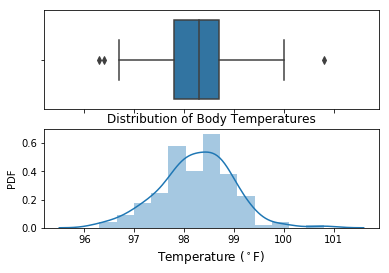

In [27]:
# Create a figure with two plots:
figure, (boxplot, histogram) = plt.subplots(2, sharex=True)
 
# Add boxplot
sns.boxplot(df.temperature, ax=boxplot)

# Add histogram
sns.distplot(df.temperature, ax=histogram)

# Label axes and add title:
plt.xlabel('Temperature ($^\circ$F)', fontsize=12)
plt.ylabel('PDF')
plt.title('Distribution of Body Temperatures', fontsize=12)

# Set default x-axis label on boxplot to not display
boxplot.set(xlabel='')

# Display the plots:
plt.show()

In [28]:
# find sample count, mean, and std distribution
sample_count = len(df['temperature'])
sample_mean = np.mean(df['temperature'])
sample_std = np.std(df['temperature'])

# Sample a normal distribution using the sample mean and std dev
sample_normal = np.random.normal(sample_mean, sample_std, size=10000)

In [29]:
# Define ECDF function
def ecdf(data):
    n = len(data) # count of samples
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [30]:
# Compute the ECDF of the actual data and the normal distribution sample
realX, realY = ecdf(df['temperature'])
normalX, normalY = ecdf(sample_normal)

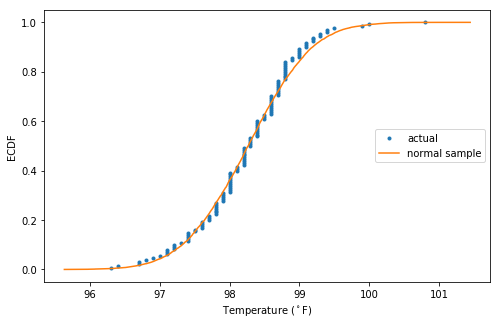

In [31]:
# Plot the ECDFs
fig = plt.figure(figsize=(8, 5))
_ = plt.plot(realX, realY, marker='.', linestyle='none')
_ = plt.plot(normalX, normalY)
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Temperature ($^\circ$F)')
_ = plt.legend(('actual', 'normal sample'), loc='center right')

From these figures, the actual data set appears to be normally distributed.

# Question 2

Is the sample size large? Are the observations independent?
* Remember that this is a condition for the CLT, and hence the statistical tests we are using, to apply.

In [32]:
print('Sample count: ', sample_count)

Sample count:  130


The sample size is 130, which is high enough for it to be considered large. The observations are independent, as they are distinct to different individuals (none of which influence the temperature of another individual).

# Question 3

Is the true population mean really 98.6 degrees F?
* Q - A. Would you use a one-sample or two-sample test? Why?
* Q - B. In this situation, is it appropriate to use the  tt  or  zz  statistic?
* Q - C. Now try using the other test. How is the result be different? Why?

* A - A. I would use a one-sample test because we have one set of data which we are comparing to a single value.
* A - B. We have a large sample size but we do not know the standard deviation of the normal population, so it seems appropriate to use a t-test rather than a z-test.
* A - C. See below

In [33]:
# Shift the data so the mean of the data is matches the conventional mean
mu = 98.6
temp_shifted = df['temperature'] - sample_mean + mu

# Define test statistic function
def t_stat(data, mu=98.6):
    return (np.mean(data) - mu) / (np.std(data) / np.sqrt(len(data)))

# Compute test statistic for data
t_obs = t_stat(df['temperature'], mu)

# Define bootstrapping functions
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    bs_reps = np.empty(size)
    for i in range(size):
        bs_reps[i] = bootstrap_replicate_1d(data, func)
    return bs_reps

# Simulate data acquisition under the null hypothesis by bootstrapping the shifted data
bs_t_reps = draw_bs_reps(temp_shifted, t_stat, size=10000)

# Compute the p-value
p_t_value = np.sum(np.abs(bs_t_reps) >= np.abs(t_obs)) / len(bs_t_reps)

print('t-statistic:', t_obs)
print('p-value: {:.2e}'.format(p_t_value))

t-statistic: -5.47592520208
p-value: 0.00e+00


The $t$-statistic is roughly -5.476. The p-value is 0, indicating that in 10,000 trials, not a single trial produced a sample mean as extreme as our observed sample mean. This being the case, we should reject the null hypothesis, meaning that the true population mean is not 98.6.

In [34]:
# Define z-statistic function
def z_stat(data, mu=98.6, sigma=0.7303577789050377):
    """Calculate z-statistic"""
    return (np.mean(data) - mu) / (sigma / np.sqrt(len(data)))

# Compute test statistic for data
z_observed = z_stat(df['temperature'], mu) 

# Simulate data acquisition under the null hypothesis by bootstrapping the shifted data
bs_z_reps = draw_bs_reps(temp_shifted, z_stat, size=10000)

# Compute the p-value
p_z_value = np.sum(np.abs(bs_z_reps) >= np.abs(z_observed)) / len(bs_z_reps)

print('z-statistic:', z_observed)
print('p-value: {:.2e}'.format(p_z_value))

z-statistic: -5.47592520208
p-value: 0.00e+00


The calculated $z$-statistic matches the $t$-statistic. Since the population standard deviation isn't known, we had to use the sample standard deviation as an approximation of the population standard deviation in our $z$-stat calculation. This, along with having a large sample size, means the two matching is fairly expected.

# Question 4.

Draw a small sample of size 10 from the data and repeat both tests.
* Q - A. Which one is the correct one to use?
* Q - B. What do you notice? What does this tell you about the difference in application of the tt and zz statistic?

* A - A. The t-test is again appropriate for this scenario, as the population standard deviation isn't known, and the sample size is small.
* A - B. See below:

In [35]:
# Seed the random number generator:
np.random.seed(15)

# Draw a random sample of 10 from the temperature data:
sample = np.random.choice(df.temperature, size=10)

# Save results of a one sample t-test:
t = stats.ttest_1samp(sample, 98.6)[0]
p = stats.ttest_1samp(sample, 98.6)[1]

print('t-statistic:', t)
print('p-value:', p)

t-statistic: -2.68826445858
p-value: 0.0248671106512


In [36]:
# Calculate and save z-statistic:
z = (np.mean(sample) - 98.6) / (np.std(sample)/np.sqrt(len(sample)))

# Calculate and save p-value:
p = stats.norm.cdf(z) * 2

# Print the values for z and p:
print('z-statistic:', z)
print('p-value:', p)

z-statistic: -2.83367954733
p-value: 0.0046015450048


In [37]:
# Print the quantiles of the t-distribution corresponding to confidence level (95%) and degrees of freedom:
print((stats.t.ppf(q=0.025, df=10-1)), (stats.t.ppf(q=0.975, df=10-1)))

-2.26215716274 2.26215716274


In [38]:
# Print the quantiles of the t-distribution corresponding to confidence level (99.9%) and degrees of freedom:
print((stats.t.ppf(q=0.0005, df=10-1)), (stats.t.ppf(q=0.9995, df=10-1)))

-4.78091258593 4.78091258593


The test statistic falls outside the t-distribution corresponding to a 95% confidence level, but not one corresponding to a 99.9% confidence level. 

The p-value for the z-test is lower than both significance levels, and the p-value for the t-test indicates significance at the 95% level. 

Both tests provide reason to reject the null hypothesis. The difference in results reflects the nature of the two distributions, and the invalidity for the z test in this scenario. The t-distribution is wider so more variability is seen. This points towards the t-test being the less sensitive of the two.

# Question 5. 

At what temperature should we consider someone's temperature to be "abnormal"?

   * Start by computing the margin of error and confidence interval.

In [39]:
# Set z value for 95% confidence interval, then calculate standard error & margin error

z = 1.96
standard_error = sample_std / np.sqrt(sample_count)
margin_error = z * standard_error

print('The margin error is {} degrees F'.format(margin_error))

The margin error is 0.125550964802579 degrees F


In [40]:
# Calculating and displaying 95% confidence interval on the mean
confidence_interval = np.percentile(df['temperature'], [2.5, 97.5])
print('The 95% confidence interval of the data is between {} and {} degrees F'.format(confidence_interval[0], confidence_interval[1]))

The 95% confidence interval of the data is between 96.7225 and 99.4775 degrees F


In [41]:
# Calculating and displaying 95% prediction interval
prediction_interval = z * sample_std / np.sqrt(1)  
print('The 95% prediction interval is {} - {} degrees F'.format(sample_mean - prediction_interval, sample_mean + prediction_interval))

The 95% prediction interval is 96.8177295225769 - 99.68073201588466 degrees F


If someone's body temperature falls outside of the prediction interval of 96.82 - 99.48 degrees F said temperature should be considered abnormal.

# Question 6.

Is there a significant difference between males and females in normal temperature?

* What test did you use and why?
* Write a story with your conclusion in the context of the original problem.

A permutation test (2-sample) with the differences in means is appropriate for approaching this problem. I'll test whether males and females have the same distribution and similar mean temperatures. First, I'll visualize the data using some introductory EDA.

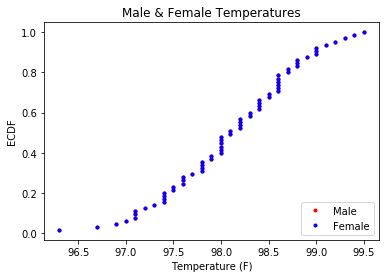

The difference between the male and female mean temperatures is 0.289230769230727 degrees F


In [42]:
# Calculate and display the ECDF for the temperatures of both males and females.

# Grab slices of the dataframes for both male and female specific temperatures
male_temperatures = df[df['gender'] == 'M']['temperature']
female_temperatures = df[df['gender'] == 'F']['temperature']

# Perform ECDF calculations for each gender subset
x_male, y_male = ecdf(male_temperatures)
x_female, y_female = ecdf(female_temperatures)

# Plot calculated ECDFs for both subsets, red for male, blue for female
plt.plot(x_male, y_male, marker='.', linestyle='none', color='red')
plt.plot(x_male, y_male, marker='.', linestyle='none', color='blue')
plt.xlabel('Temperature (F)')
plt.ylabel('ECDF')
plt.legend(('Male', 'Female'), loc='lower right')
plt.title('Male & Female Temperatures')
plt.show()

# Calculate and display difference between gender specific subsets
male_female_diff = np.abs(np.mean(male_temperatures) - np.mean(female_temperatures))
print('The difference between the male and female mean temperatures is {} degrees F'.format(male_female_diff))

The plotted ECDFs for both genders overlap signifying a very little difference between the two sets of data (0.289 degrees F). From here, we can use permutation testing to simulate the hypothesis that the two genders have identical probability distributions. 

We're using this hypothesis testing to examine whether the small observed difference is due to the differences in gender or by chance. Our null hypothesis is that the distributions of temperatures for males and females are identical.

In [43]:
# Define test statistic 
def diff_of_means(first_data_set, second_data_set):
    return np.mean(first_data_set) - np.mean(second_data_set)

# Compute test statistic for the observed data
diff_obs = diff_of_means(female_temperatures, male_temperatures)

# Draw permutation replicates, permute observed data, draw replicates
perm_replicates = np.empty(10000)
for i in range(len(perm_replicates)): 
    combined = np.concatenate((female_temperatures, male_temperatures))
    perm_combined = np.random.permutation(combined)
    perm_females = perm_combined[:len(female_temperatures)]
    perm_males = perm_combined[len(female_temperatures):]
    perm_replicates[i] = diff_of_means(perm_females, perm_males)

# Compute p-value
p_value = np.sum(abs(perm_replicates) >= abs(diff_obs)) / len(perm_replicates)

print('The observed difference: {} degrees F'.format(diff_obs))
print('p-value: {}'.format(p_value))

The observed difference: 0.289230769230727 degrees F
p-value: 0.0258


Since our p-value is less than 0.05, we must reject the null hypothesis. This means that a statistically significant difference between the distribution of male and female temperatures exists, and the normal temperatures for males and females differ by a statistically significant amount.

# Conclusion

The mean normal body temperature has been held to be 37$^∘$ C or 98.6$^∘$ F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. However, our analysis indicates that this value is not statistically accurate. Instead, we found that the mean normal body temperature was computed with 95% confidence to be between 98.124 and 98.376 (with a 95% confidence interval). 

Additionally, we discovered a statistically significant difference between male and female temperatures of approximately 0.29$^{\circ}$F. Females tend to have slightly warmer body temperatures than males.